In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import re

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# linear models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# non-linear models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

# ensemble models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

# pipeline
from sklearn.pipeline import Pipeline

# confusion matrix
from sklearn.metrics import confusion_matrix, precision_recall_curve,auc, roc_auc_score, roc_curve, recall_score, classification_report

from sklearn.cross_validation import train_test_split, KFold, cross_val_score

In [2]:
# modified dataset
train_data_path = '../Dataset/sentiment140/modified/train/modified_train_data.csv'

In [3]:
pd.set_option("display.max_columns", 101)

ori_train_data = pd.read_csv(train_data_path)

In [4]:
# copy the dataframe
copied_train_data = ori_train_data.copy()

In [5]:
copied_train_data.head()

,polarity,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# select only polarity and tweet from the dataset
copied_train_data = copied_train_data[['polarity', 'tweet']]

In [7]:
copied_train_data.head()

,polarity,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
def preprocess_data(data):
    
    mod_tweet = []
    mod_polarity = []
    
    for index, row in data.iterrows():
        tweet = row['tweet']    
        cleaned_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", tweet).split())
        mod_tweet.append(cleaned_tweet)
        
        polarity = row['polarity']
        if polarity == 0: # negative
            mod_polarity.append(0)
        else:
            mod_polarity.append(1)
    
    data['mod_tweet'] = mod_tweet
    data['mod_polarity'] = mod_polarity

In [9]:
preprocess_data(copied_train_data)

In [10]:
# option 1
copied_train_data = copied_train_data.drop(['polarity', 'tweet'], axis=1)

In [11]:
# preprocessed train data
copied_train_data.head()

,mod_tweet,mod_polarity
0,Awww that s a bummer You shoulda got David Car...,0
1,is upset that he can t update his Facebook by ...,0
2,I dived many times for the ball Managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [12]:
# print shape before removing neutral polarity=2
copied_train_data.shape

(1600000, 2)

In [13]:
# print datatypes
copied_train_data.dtypes

mod_tweet       object
mod_polarity     int64
dtype: object

# Scikit-learn

In [14]:
features = copied_train_data['mod_tweet']
target = copied_train_data['mod_polarity']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [16]:
# Test options and evaluation metric
num_folds = 10
scoring = "accuracy"

In [18]:
# Standardize the dataset
pipelines = []

pipelines.append(("TokenizedLR", Pipeline([('vect', CountVectorizer(encoding='latin-1', lowercase=True)), 
                                           ('tfidf', TfidfTransformer()), 
                                           ("LR", LogisticRegression())])))

pipelines.append(("TokenizedNB", Pipeline([('vect', CountVectorizer(encoding='latin-1', lowercase=True)),
                                           ('tfidf', TfidfTransformer()),
                                           ("MNB", MultinomialNB())])))

results = []
names = []

for name, model in pipelines:
#   kfold = KFold(n_splits=num_folds, random_state=666)
  kfold = KFold(X_train.shape[0], 10, random_state=666)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

TokenizedLR: 0.798821 (0.001058)
TokenizedNB: 0.772852 (0.000950)


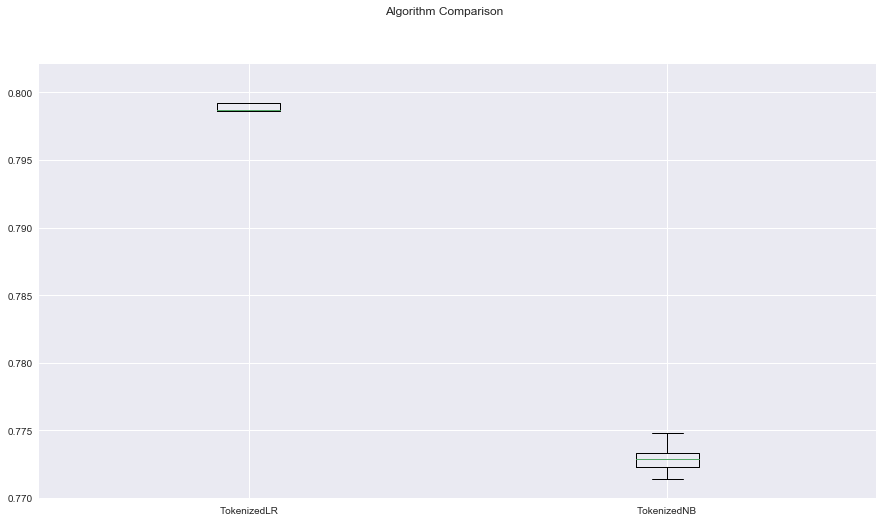

In [19]:
# Compare Algorithms
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()